# Lets See How The Disc Models Preformed

This notebook is designed to analyze the disc models performance and to answer the question does Long Short Term Memory Neural Net (LSTM) outperform SparseLogisticRegression (SLR).

## MUST RUN AT THE START OF EVERYTHING

Load the database and other helpful functions for analysis.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import csv
import glob
import os

from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
from scipy.stats import norm
import seaborn as sns
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve
from sklearn.metrics import auc, f1_score, confusion_matrix
import tqdm

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.annotations import FeatureAnnotator, LabelAnnotator, load_marginals
from snorkel.models import Candidate, candidate_subclass
from snorkel.viewer import SentenceNgramViewer

In [4]:
edge_type = "dg"

In [5]:
if edge_type == "dg":
    DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])
elif edge_type == "gg":
    GeneGene = candidate_subclass('GeneGene', ['Gene1', 'Gene2'])
elif edge_type == "cg":
    CompoundGene = candidate_subclass('CompoundGene', ['Compound', 'Gene'])
elif edge_type == "cd":
    CompoundDisease = candidate_subclass('CompoundDisease', ['Compound', 'Disease'])
else:
    print("Please pick a valid edge type")

# Load the data

Here is where we load the test dataset in conjunction with the previously trained disc models. Each algorithm will output a probability of a candidate being a true candidate.

In [6]:
dev_sentence_df = pd.read_excel("data/sentence-labels-dev.xlsx")
dev_sentence_df = dev_sentence_df[dev_sentence_df.curated_dsh.notnull()]
dev_sentence_df = dev_sentence_df.sort_values("candidate_id")
dev_sentence_df.head(2)

,candidate_id,disease,gene,doid_id,entrez_gene_id,sentence,label,doid_name,gene_symbol,LF_HETNET_DISEASES,...,LF_HETNET_ABSENT,LF_CHECK_GENE_TAG,LF_IS_BIOMARKER,LF_ASSOCIATION,LF_NO_ASSOCIATION,LF_NO_CONCLUSION,LF_DG_DISTANCE,LF_NO_VERB,curated_dsh,notes_dsh
74,228511,AML,TNF alpha,DOID:2531,7124,"However, addition of anti-TNF alpha (every 72 ...",0.286983,hematologic cancer,TNF,1,...,0,0,0,1,0,0,0,0,1.0,NaN
18,235489,non-Hodgkin's lymphomas,c-myc,DOID:0060073,4609,Steady state c-myc mRNA levels determined by N...,0.700525,lymphatic system cancer,MYC,0,...,-1,0,0,0,0,-1,0,0,0.0,NaN


In [8]:
marginals_df = pd.read_table('data/disease_gene/disease_associates_gene/disc_model_marginals_26lfs_250k.tsv')
marginals_df.head(2)

,Bag of Words,Doc2Vec 50k,Doc2Vec 500k,Doc2Vec All,LSTM
0,0.999081,0.999986,0.648162,0.380502,0.867950
1,0.793671,1.000000,0.590818,0.565288,0.836592


In [9]:
dev_sentence_df.curated_dsh.value_counts()

0.0    129
1.0     81
Name: curated_dsh, dtype: int64

# Accuracy ROC

From the probabilities calculated above, we can create a [Receiver Operator Curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) (ROC) graph to measure the false positive rate and the true positive rate at each calculated threshold.

In [10]:
model_aucs = {}

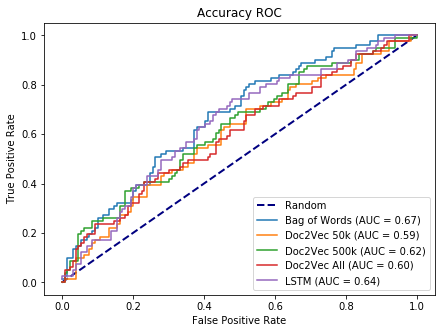

In [11]:
plt.figure(figsize=(7,5))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random")

for model in marginals_df.columns:
    fpr, tpr, _= roc_curve(dev_sentence_df.curated_dsh.values, marginals_df[model])
    model_auc = auc(fpr, tpr)
    model_aucs[model] = model_auc
    plt.plot(fpr, tpr, label="{} (AUC = {:0.2f})".format(model, model_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Accuracy ROC')
plt.legend(loc="lower right")

## Statistical Significance for ROC

This block of code calculates the p-value for each ROC curve above. Each AUC is equivalent to the Mann-Whitney U statistic (aka Willcoxon Rank Sum Test). Calulating this statistic is easy and the equation can be found [here](https://www.quora.com/How-is-statistical-significance-determined-for-ROC-curves-and-AUC-values). Since more than 20 data points were used to generate the above ROC curves, normal approximation canm used to calculate the p-values. The equaltions for the normal approximation can be found [here](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test). Looking at the bottom dataframe, one can see there isn't strong evidence that the generated ROCs are greater than 0.50.

In [12]:
class_dist_df = dev_sentence_df.curated_dsh.value_counts()
n1 = class_dist_df[0]
n2 = class_dist_df[1]
mu = (n1*n2)/2
sigma_u = np.sqrt((n1 * n2 * (n1+n2+1))/12)
print("mu: {:f}, sigma: {:f}".format(mu, sigma_u))

mu: 5224.500000, sigma: 428.635335


In [13]:
model_auc_df = pd.DataFrame.from_dict(model_aucs, orient='index')
model_auc_df = model_auc_df.rename(index=str, columns={0:'auroc'})
model_auc_df.head(2)

,auroc
Bag of Words,0.668007
Doc2Vec 50k,0.594315


In [14]:
model_auc_df['u'] = model_auc_df.auroc.apply(lambda x: x*n1*n2)
model_auc_df['z_u'] = model_auc_df.u.apply(lambda z_u: (z_u- mu)/sigma_u)
model_auc_df.head(2)

,auroc,u,z_u
Bag of Words,0.668007,6980.0,4.095556
Doc2Vec 50k,0.594315,6210.0,2.299157


In [15]:
model_auc_df['p_value'] = model_auc_df.z_u.apply(lambda z_u: norm.sf(z_u, loc=0, scale=1))
model_auc_df

,auroc,u,z_u,p_value
Bag of Words,0.668007,6980.0,4.095556,0.000021
Doc2Vec 50k,0.594315,6210.0,2.299157,0.010748
Doc2Vec 500k,0.624079,6521.0,3.024716,0.001244
Doc2Vec All,0.599196,6261.0,2.418139,0.007800
LSTM,0.640635,6694.0,3.428322,0.000304


# Precision vs Recall Curve

This code produces a [Precision-Recall](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) graph, which shows the trade off between [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) at each given probability threshold.

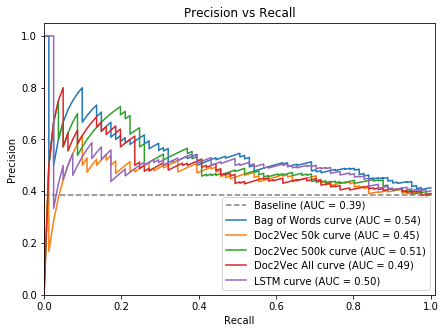

In [16]:
plt.figure(figsize=(7,5))

positive_class = dev_sentence_df.curated_dsh.values.sum()/dev_sentence_df.shape[0]
plt.plot([0,1], [positive_class, positive_class], color='grey', 
         linestyle='--', label='Baseline (AUC = {:0.2f})'.format(positive_class))

for model in marginals_df.columns:
    precision, recall, _ = precision_recall_curve(dev_sentence_df.curated_dsh.values, marginals_df[model])
    model_auc = auc(recall, precision)
    plt.plot(recall, precision, label="{} curve (AUC = {:0.2f})".format(model, model_auc))

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision vs Recall')
plt.xlim([0, 1.01])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")

# Old vs New

In [17]:
marginals_17_df = pd.read_table('data/disease_gene/disease_associates_gene/disc_model_marginals_17lfs.tsv')
marginals_26_50k_df = pd.read_table('data/disease_gene/disease_associates_gene/disc_model_marginals_26lfs_50k.tsv')
marginals_26_250k_df = pd.read_table('data/disease_gene/disease_associates_gene/disc_model_marginals_26lfs_250k.tsv')

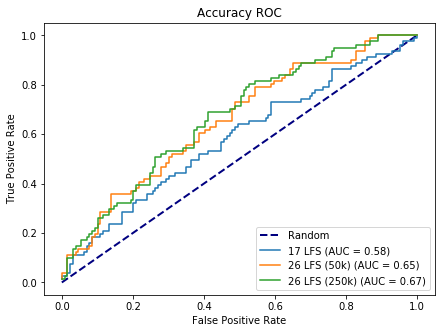

In [18]:
plt.figure(figsize=(7,5))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random")

fpr, tpr, _= roc_curve(dev_sentence_df.curated_dsh.values, marginals_17_df['Doc2Vec All'])
model_auc = auc(fpr, tpr)
model_aucs[model] = model_auc
plt.plot(fpr, tpr, label="{} (AUC = {:0.2f})".format('17 LFS', model_auc))

fpr, tpr, _= roc_curve(dev_sentence_df.curated_dsh.values, marginals_26_50k_df['LSTM'])
model_auc = auc(fpr, tpr)
model_aucs[model] = model_auc
plt.plot(fpr, tpr, label="{} (AUC = {:0.2f})".format('26 LFS (50k)', model_auc))

fpr, tpr, _= roc_curve(dev_sentence_df.curated_dsh.values, marginals_26_250k_df['Bag of Words'])
model_auc = auc(fpr, tpr)
model_aucs[model] = model_auc
plt.plot(fpr, tpr, label="{} (AUC = {:0.2f})".format('26 LFS (250k)', model_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Accuracy ROC')
plt.legend(loc="lower right")

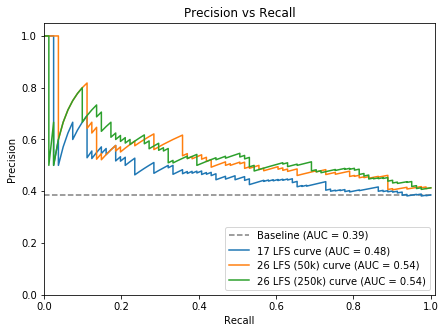

In [19]:
plt.figure(figsize=(7,5))

positive_class = dev_sentence_df.curated_dsh.values.sum()/dev_sentence_df.shape[0]
plt.plot([0,1], [positive_class, positive_class], color='grey', 
         linestyle='--', label='Baseline (AUC = {:0.2f})'.format(positive_class))

precision, recall, _ = precision_recall_curve(dev_sentence_df.curated_dsh.values, marginals_17_df['Doc2Vec All'])
model_auc = auc(recall, precision)
plt.plot(recall, precision, label="{} curve (AUC = {:0.2f})".format('17 LFS', model_auc))

precision, recall, _ = precision_recall_curve(dev_sentence_df.curated_dsh.values, marginals_26_50k_df['LSTM'])
model_auc = auc(recall, precision)
plt.plot(recall, precision, label="{} curve (AUC = {:0.2f})".format('26 LFS (50k)', model_auc))

precision, recall, _ = precision_recall_curve(dev_sentence_df.curated_dsh.values, marginals_26_250k_df['Bag of Words'])
model_auc = auc(recall, precision)
plt.plot(recall, precision, label="{} curve (AUC = {:0.2f})".format('26 LFS (250k)', model_auc))


plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision vs Recall')
plt.xlim([0, 1.01])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")